# Построение графа из транзакций

Главная идея:

Каждая строка = одна вершина (узел, node) графа

Рёбра (связи) между узлами добавляются по какому-то смысловому принципу (например: общий номер карты, имейл, адрес, device и т.п.)

Пример: Связываем все транзакции с одинаковой card1

In [16]:
import pandas as pd
df = pd.read_csv('../data/processing/df_preprocessing.csv') # Твой датасет

In [17]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(
    df, test_size=0.2, shuffle=False
)

In [ ]:
import numpy as np
import torch
from torch_geometric.data import Data

def create_graph(df: pd.DataFrame):
    #for col in ['ProductCD', 'card4', 'card6', 'P_emaildomain']:
    #    le = LabelEncoder()
    #    df[col] = le.fit_transform(df[col].astype(str))

    # Выбираем признаки для узлов:
    feature_cols = [
        'ProductCD', 'card1', 'card2', 'card3',
        'card4', 'card5', 'card6', 'addr1', 'addr2', 'P_emaildomain',
        'Relative_TransactionDT', 'Transaction_day', 'Transaction_hour',
        'Transaction_weekday', 'log_TransactionAmt', 'TransactionAmt_binned',
        'isOutlier',
        'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D4', 'D10', 'D15', 'M6', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65', 'V66', 'V67', 'V68', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74', 'V75', 'V76', 'V77', 'V78', 'V79', 'V80', 'V81', 'V82', 'V83', 'V84', 'V85', 'V86', 'V87', 'V88', 'V89', 'V90', 'V91', 'V92', 'V93', 'V94', 'V95', 'V96', 'V97', 'V98', 'V99', 'V100', 'V101', 'V102', 'V103', 'V104', 'V105', 'V106', 'V107', 'V108', 'V109', 'V110', 'V111', 'V112', 'V113', 'V114', 'V115', 'V116', 'V117', 'V118', 'V119', 'V120', 'V121', 'V122', 'V123', 'V124', 'V125', 'V126', 'V127', 'V128', 'V129', 'V130', 'V131', 'V132', 'V133', 'V134', 'V135', 'V136', 'V137', 'V279', 'V280', 'V281', 'V282', 'V283', 'V284', 'V285', 'V286', 'V287', 'V288', 'V289', 'V290', 'V291', 'V292', 'V293', 'V294', 'V295', 'V296', 'V297', 'V298', 'V299', 'V300', 'V301', 'V302', 'V303', 'V304', 'V305', 'V306', 'V307', 'V308', 'V309', 'V310', 'V311', 'V312', 'V313', 'V314', 'V315', 'V316', 'V317', 'V318', 'V319', 'V320', 'V321'
    ]
    x = torch.tensor(df[feature_cols].values, dtype=torch.float)

    # Формируем ребра: все пары транзакций с одинаковой 'card1'
    edges = []
    groups = df.groupby('card1').groups
    for card, idxs in groups.items():
        idxs = list(idxs)
        for i in range(len(idxs)):
            for j in range(i+1, len(idxs)):
                edges.append([idxs[i], idxs[j]])
                edges.append([idxs[j], idxs[i]])
    edge_index = torch.tensor(np.array(edges).T, dtype=torch.long)  # размер [2, num_edges]

    y = torch.tensor(df['isFraud'].values, dtype=torch.long)

    return Data(x=x, edge_index=edge_index, y=y)

In [19]:
import pandas as pd
import numpy as np
import torch
from torch_geometric.data import Data

#df = pd.read_csv('../data/processing/df_preprocessing.csv') # Твой датасет
#
## Преобразуем категориальные
#from sklearn.preprocessing import LabelEncoder
#for col in ['ProductCD', 'card4', 'card6', 'P_emaildomain']:
#    le = LabelEncoder()
#    df[col] = le.fit_transform(df[col].astype(str))
#
## Выбираем признаки для узлов:
#feature_cols = [
#    'ProductCD', 'card1', 'card2', 'card3',
#    'card4', 'card5', 'card6', 'addr1', 'addr2', 'P_emaildomain',
#    'Relative_TransactionDT', 'Transaction_day', 'Transaction_hour',
#    'Transaction_weekday', 'log_TransactionAmt', 'TransactionAmt_binned',
#    'isOutlier'
#]
#x = torch.tensor(df[feature_cols].values, dtype=torch.float)
#
## Формируем ребра: все пары транзакций с одинаковой 'card1'
#edges = []
#groups = df.groupby('card1').groups
#for card, idxs in groups.items():
#    idxs = list(idxs)
#    for i in range(len(idxs)):
#        for j in range(i+1, len(idxs)):
#            edges.append([idxs[i], idxs[j]])
#            edges.append([idxs[j], idxs[i]])
#edge_index = torch.tensor(np.array(edges).T, dtype=torch.long)  # размер [2, num_edges]
#
#y = torch.tensor(df['isFraud'].values, dtype=torch.long)

#data = Data(x=x, edge_index=edge_index, y=y)
train_data = create_graph(train_df)
train_data

ValueError: No axis named card2 for object type DataFrame

In [5]:
test_data = create_graph(test_df)
test_data

Data(x=[79136, 205], edge_index=[2, 28264904], y=[79136])

In [6]:
from torch_geometric.loader import NeighborLoader

# Пусть у тебя граф data как выше

batch_size = 512  # Сколько узлов (транзакций) в одном батче
num_neighbors = [10, 5]  # Сколько соседей собирать на 1-м и 2-м слоях

train_loader = NeighborLoader(
    train_data,
    num_neighbors=num_neighbors,
    batch_size=batch_size,
    shuffle=False,  # в обучении должен быть shuffle
)

for batch in train_loader:
    print(batch)
    break
    # batch — это subgraph PyG Data
    # batch.x — признаки только выборки и соседей
    # batch.edge_index — рёбра внутри subgraph
    # batch.y — метки
    # batch.batch_size — число целевых узлов в батче (остальные — только соседи)
    # batch.n_id — индексы оригинальных узлов (если надо сопоставлять)
    ##logits = model(batch.x, batch.edge_index)
    # обычно batch.y[:batch.batch_size] — только лейблы тех, что в батче, а не у всех соседей
    ##loss = loss_fn(logits[:batch.batch_size], batch.y[:batch.batch_size])
    ##loss.backward()
    ##optimizer.step()
    ##...

Data(x=[23135, 205], edge_index=[2, 28361], y=[23135], n_id=[23135], e_id=[28361], input_id=[512], batch_size=512)


In [7]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class SimpleGNN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim=1):
        super().__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x.squeeze()

In [8]:
class GCNWithLinear(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim=1):
        super().__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.lin = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.lin(x)
        return x.squeeze()

In [9]:
# 🔁 Обучение
def train(model, loader: NeighborLoader, epochs=100, lr=0.01):
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCEWithLogitsLoss()

    for epoch in range(epochs):

        for batch in loader:
            #print(batch)
            optimizer.zero_grad()
            logits = model(batch.x, batch.edge_index)
            #обычно batch.y[:batch.batch_size] — только лейблы тех, что в батче, а не у всех соседей
            loss = criterion(logits[:batch.batch_size], batch.y[:batch.batch_size].float())
            loss.backward()
            optimizer.step()
        
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
model_simple_gnn = SimpleGNN(input_dim=train_data.x.shape[1], hidden_dim=32).to(device)
#data = data.to(device)

train(model=model_simple_gnn, loader=train_loader, epochs=20, lr=0.01)

Epoch 0, Loss: 4793.4751
Epoch 1, Loss: 1663.3712
Epoch 2, Loss: 338.7679
Epoch 3, Loss: 48.7515
Epoch 4, Loss: 1.4042
Epoch 5, Loss: 0.0967
Epoch 6, Loss: 0.0957
Epoch 7, Loss: 0.0954
Epoch 8, Loss: 0.0876
Epoch 9, Loss: 0.0874
Epoch 10, Loss: 0.0883
Epoch 11, Loss: 0.0954
Epoch 12, Loss: 0.0864
Epoch 13, Loss: 0.0857
Epoch 14, Loss: 0.0919
Epoch 15, Loss: 0.0909
Epoch 16, Loss: 0.0937
Epoch 17, Loss: 0.0907
Epoch 18, Loss: 0.0913
Epoch 19, Loss: 0.0939


In [11]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_score, recall_score
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt

# 📊 Тест
@torch.no_grad()
def evaluate(model, loader: NeighborLoader, name="Model"):
    model.eval()

    all_true = []
    all_probs = []
    all_preds = []
    for batch in loader:
        # Если используешь device:
        # batch = batch.to(device)
        logits = model(batch.x, batch.edge_index)
        # Только для центрального батча:
        logits = logits[:batch.batch_size]
        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).long()
        true = batch.y[:batch.batch_size].long()
        all_true.append(true.cpu())
        all_probs.append(probs.cpu())
        all_preds.append(preds.cpu())

    all_true = torch.cat(all_true).numpy()
    all_probs = torch.cat(all_probs).numpy()
    all_preds = torch.cat(all_preds).numpy()


    # 🎯 ROC AUC
    fpr, tpr, _ = roc_curve(all_true, all_probs)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title("ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

    # 🎯 PR AUC
    precision, recall, _ = precision_recall_curve(true, probs)
    pr_auc = auc(recall, precision)

    plt.figure(figsize=(6, 5))
    plt.plot(recall, precision, label=f"{name} (PR AUC = {pr_auc:.2f})")
    plt.title("Precision-Recall Curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend(loc="upper right")
    plt.grid(True)
    plt.show()

    return {
        "Accuracy": accuracy_score(true, preds),
        "F1": f1_score(true, preds),
        "AUC": roc_auc_score(true, probs),
        "Precision": precision_score(true, preds),
        "Recall": recall_score(true, preds)
    }

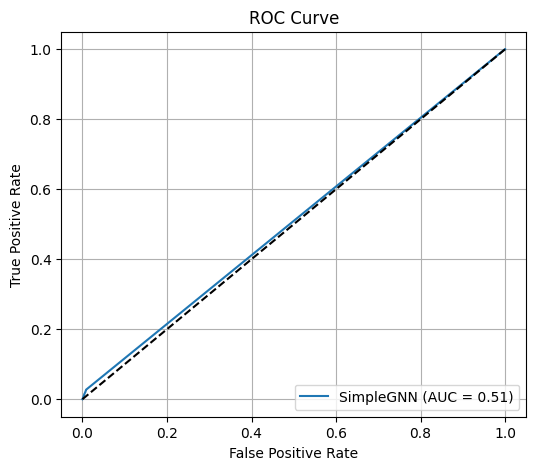

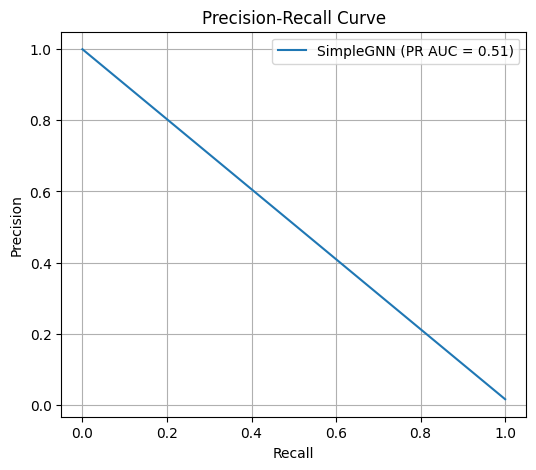

/Users/sergey/Projects/Karpov.Courses/mfdp-fin-fraud-detection/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'Accuracy': 0.984,
 'F1': 0.0,
 'AUC': np.float64(0.5),
 'Precision': 0.0,
 'Recall': 0.0}

In [13]:
evaluate(model=model_simple_gnn, loader=train_loader, name='Train SimpleGNN')

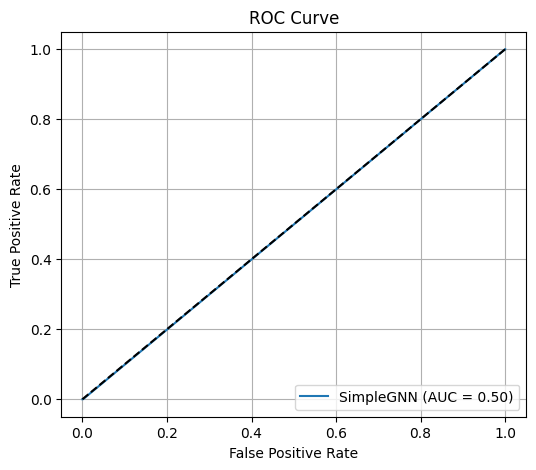

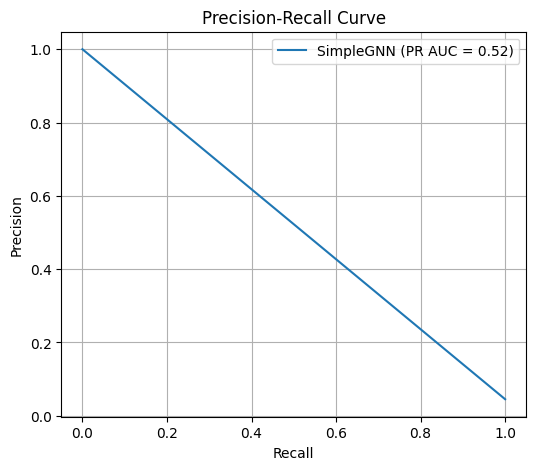

/Users/sergey/Projects/Karpov.Courses/mfdp-fin-fraud-detection/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'Accuracy': 0.9548611111111112,
 'F1': 0.0,
 'AUC': np.float64(0.5),
 'Precision': 0.0,
 'Recall': 0.0}

In [ ]:
batch_size = 512  # Сколько узлов (транзакций) в одном батче
num_neighbors = [10, 5]  # Сколько соседей собирать на 1-м и 2-м слоях

test_loader = NeighborLoader(
    test_data,
    num_neighbors=num_neighbors,
    batch_size=batch_size,
    shuffle=False,  # в обучении должен быть shuffle
)

evaluate(model=model_simple_gnn, loader=test_loader, name='Test SimpleGNN')